PHÂN TÍCH DỮ LIỆU US BABY NAME 1880-2010

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!pip install pandas matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [ ]:
# Đường dẫn file bạn đã lưu
zip_path = "/content/drive/MyDrive/PTDL/bt lap 2/names.zip"

# Tạo thư mục đích (nếu chưa có)
!mkdir -p /content/datasets/babynames

# Giải nén file zip vào thư mục datasets/babynames
!unzip -q "{zip_path}" -d /content/datasets/babynames

# Kiểm tra vài file đầu tiên sau khi giải nén
!ls /content/datasets/babynames | head




NationalReadMe.pdf
yob1880.txt
yob1881.txt
yob1882.txt
yob1883.txt
yob1884.txt
yob1885.txt
yob1886.txt
yob1887.txt
yob1888.txt


In [ ]:
import pandas as pd
import os

data_path = "/content/datasets/babynames/"
pieces = []

for year in range(1880, 2011):
    file_path = os.path.join(data_path, f"yob{year}.txt")
    df = pd.read_csv(file_path, names=["name", "sex", "births"])
    df["year"] = year
    pieces.append(df)

names = pd.concat(pieces, ignore_index=True)
names.head()



,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [ ]:
# Xóa dòng trống (nếu có)
names.dropna(inplace=True)

# Chuẩn hóa tên (viết hoa chữ đầu)
names["name"] = names["name"].astype(str).str.strip().str.title()

# Giới tính chỉ giữ M/F
names = names[names["sex"].isin(["M", "F"])]

# Sắp xếp theo năm
names.sort_values(by=["year", "sex", "births"], ascending=[True, True, False], inplace=True)

# Lưu lại file CSV mới
output_path = "/content/drive/MyDrive/PTDL/bt lap 2/babynames.csv"
names.to_csv(output_path, index=False, encoding="utf-8")

print(f"✅ Đã lưu file sạch thành công tại: {output_path}")


✅ Đã lưu file sạch thành công tại: /content/drive/MyDrive/PTDL/bt lap 2/babynames.csv


Đọc và ghép nối dữ liệu các năm (1880–2010)

In [ ]:
# Đường dẫn file CSV đã có sẵn
csv_path = "/content/drive/MyDrive/PTDL/bt lap 2/babynames.csv"

# Đọc dữ liệu
names = pd.read_csv(csv_path)

# Xem 5 dòng đầu
names.head()


,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


Thống kê tổng quan

In [ ]:
print("TỔNG QUAN DỮ LIỆU:")
print(f"- Tổng số dòng dữ liệu: {len(names):,}")
print(f"- Số năm: {names['year'].nunique()}")
print(f"- Số tên khác nhau: {names['name'].nunique():,}")
print(f"- Giai đoạn: {names['year'].min()} – {names['year'].max()}")
print(f"- Số giới tính: {names['sex'].nunique()} (F, M)")


TỔNG QUAN DỮ LIỆU:
- Tổng số dòng dữ liệu: 1,692,632
- Số năm: 131
- Số tên khác nhau: 88,665
- Giai đoạn: 1880 – 2010
- Số giới tính: 2 (F, M)


Tổng số trẻ sinh theo giới tính qua thời gian

/tmp/ipython-input-1901756893.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_births = names.pivot_table("births", index="year", columns="sex", aggfunc=sum)


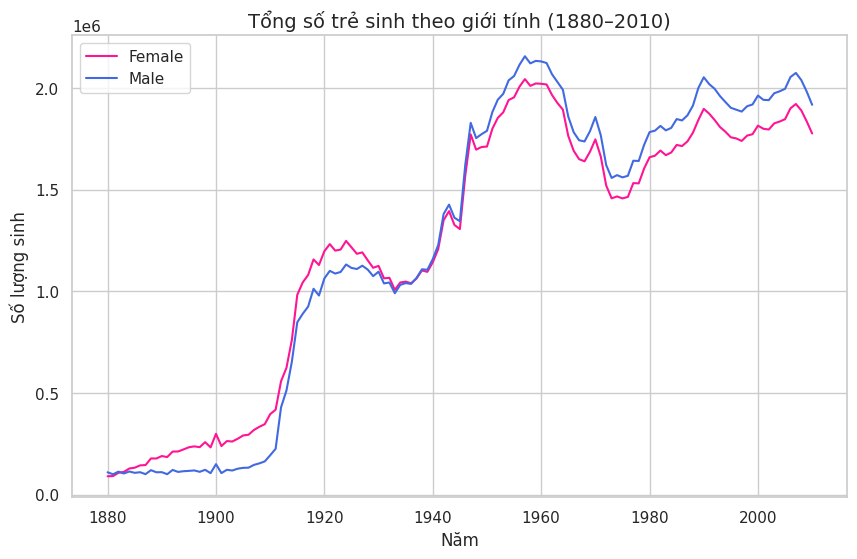

In [ ]:
total_births = names.pivot_table("births", index="year", columns="sex", aggfunc=sum)

plt.figure(figsize=(10,6))
plt.plot(total_births.index, total_births["F"], label="Female", color="deeppink")
plt.plot(total_births.index, total_births["M"], label="Male", color="royalblue")
plt.title("Tổng số trẻ sinh theo giới tính (1880–2010)", fontsize=14)
plt.xlabel("Năm")
plt.ylabel("Số lượng sinh")
plt.legend()
plt.show()


  Nhận xét: Số trẻ sinh tăng mạnh đến giữa thế kỷ 20 rồi giảm nhẹ. Bé trai luôn nhiều hơn bé gái.

Thêm cột prop (tỷ lệ %)

In [ ]:
def add_prop(group):
    group["prop"] = group["births"] / group["births"].sum()
    return group

names = names.groupby(["year", "sex"]).apply(add_prop)
names.head()


/tmp/ipython-input-2562339431.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  names = names.groupby(["year", "sex"]).apply(add_prop)


name sex  births  year      prop
year sex                                         
1880 F   0       Mary   F    7065  1880  0.077642
         1       Anna   F    2604  1880  0.028617
         2       Emma   F    2003  1880  0.022012
         3  Elizabeth   F    1939  1880  0.021309
         4     Minnie   F    1746  1880  0.019188

Lấy Top 1000 tên phổ biến nhất mỗi năm

In [ ]:
# Đảm bảo index sạch, không còn trùng 'year'
names = names.reset_index(drop=True)

# Hàm chọn top 1000
def get_top1000(group):
    return group.sort_values("births", ascending=False).head(1000)

# Nhóm theo year, sex
grouped = names.groupby(["year", "sex"], group_keys=False)

# Áp dụng hàm lấy top 1000
top1000 = grouped.apply(get_top1000).reset_index(drop=True)

# Hiển thị kết quả
top1000.head()


/tmp/ipython-input-822714031.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top1000 = grouped.apply(get_top1000).reset_index(drop=True)


,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


from matplotlib import pyplot as plt
_df_0['births'].plot(kind='hist', bins=20, title='births')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['prop'].plot(kind='hist', bins=20, title='prop')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='births', y='prop', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['births']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('births')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['year']
  ys = series['prop']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('prop')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'year'}, axis=1)
              .sort_values('year', ascending=True))
  xs = counted['year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('name')):
  _plot_series(series, series_name, i)
  fig.legend(title='name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['births'].plot(kind='line', figsize=(8, 4), title='births')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['prop'].plot(kind='line', figsize=(8, 4), title='prop')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='births', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='prop', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Xu hướng các tên phổ biến theo thời gian , Ví dụ: John, Harry, Mary, Marilyn

/tmp/ipython-input-4119745256.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  subset = top1000.pivot_table("births", index="year", columns="name", aggfunc=sum)[["John", "Harry", "Mary", "Marilyn"]]


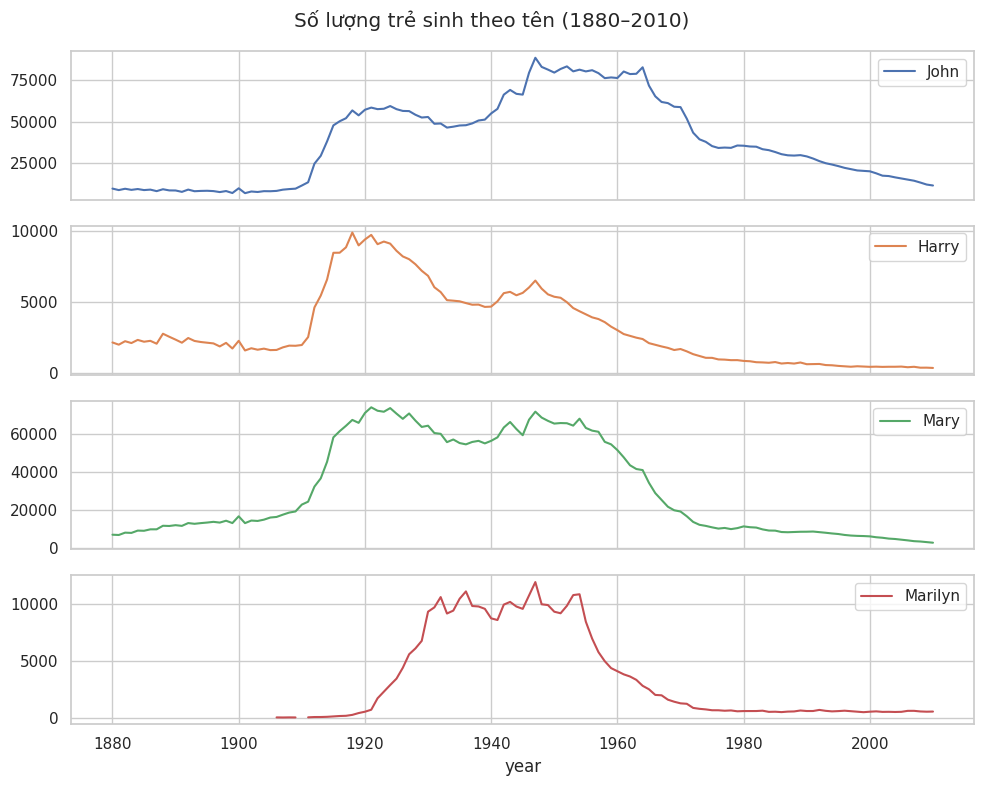

In [ ]:
subset = top1000.pivot_table("births", index="year", columns="name", aggfunc=sum)[["John", "Harry", "Mary", "Marilyn"]]

subset.plot(subplots=True, figsize=(10,8), title="Số lượng trẻ sinh theo tên (1880–2010)")
plt.tight_layout()
plt.show()


Nhận xét: Tên truyền thống như Mary và John giảm mạnh sau 1960, phản ánh xu hướng thay đổi trong đặt tên.

Độ đa dạng trong đặt tên (Diversity Trend)

/tmp/ipython-input-389536578.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  div_table = top1000.pivot_table("prop", index="year", columns="sex", aggfunc=sum)


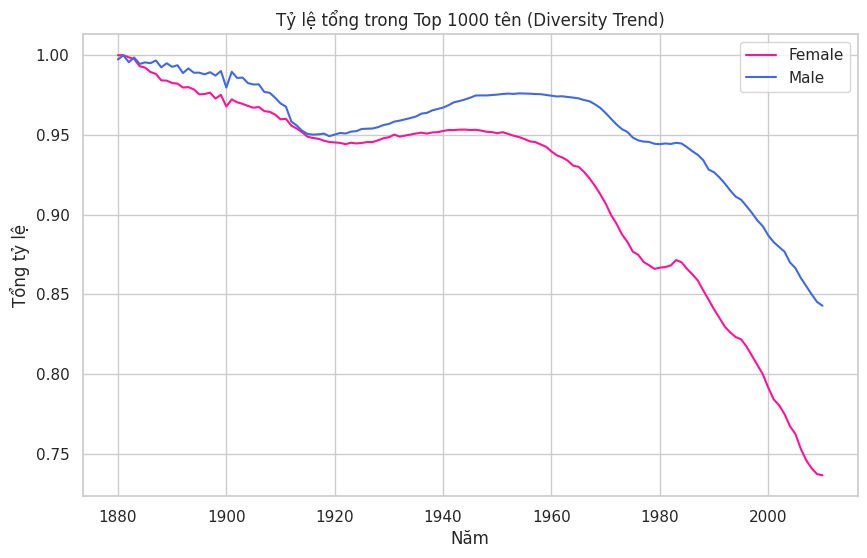

In [ ]:
div_table = top1000.pivot_table("prop", index="year", columns="sex", aggfunc=sum)

plt.figure(figsize=(10,6))
plt.plot(div_table.index, div_table["F"], label="Female", color="deeppink")
plt.plot(div_table.index, div_table["M"], label="Male", color="royalblue")
plt.title("Tỷ lệ tổng trong Top 1000 tên (Diversity Trend)")
plt.xlabel("Năm")
plt.ylabel("Tổng tỷ lệ")
plt.legend()
plt.show()


Nhận xét: Tổng tỷ lệ Top 1000 giảm dần theo thời gian → độ đa dạng tên tăng lên rõ rệt.

Số lượng tên chiếm 50% tổng số trẻ sinh

/tmp/ipython-input-2856172535.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diversity = top1000.groupby(["year","sex"]).apply(get_quantile_count).unstack()


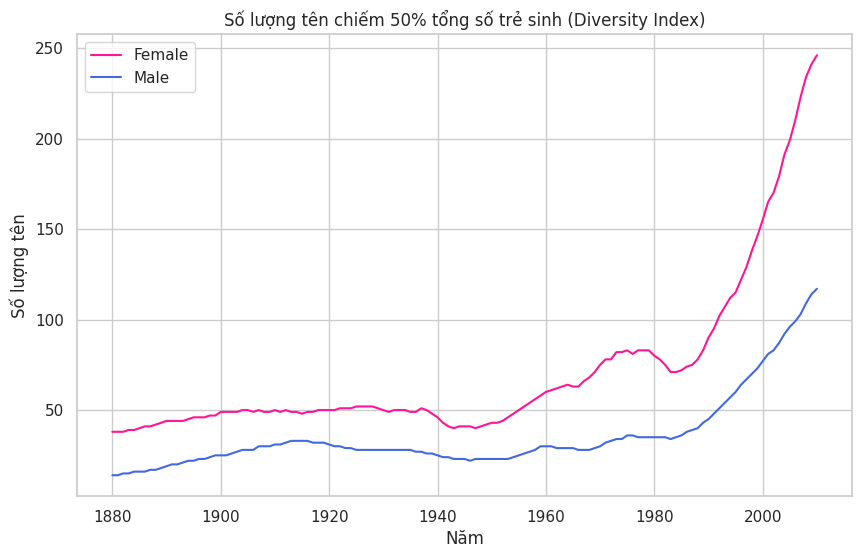

In [ ]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values("prop", ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000.groupby(["year","sex"]).apply(get_quantile_count).unstack()

plt.figure(figsize=(10,6))
plt.plot(diversity.index, diversity["F"], label="Female", color="deeppink")
plt.plot(diversity.index, diversity["M"], label="Male", color="royalblue")
plt.title("Số lượng tên chiếm 50% tổng số trẻ sinh (Diversity Index)")
plt.xlabel("Năm")
plt.ylabel("Số lượng tên")
plt.legend()
plt.show()


Nhận xét:

Bé gái luôn có nhiều tên đa dạng hơn bé trai.

Độ đa dạng tăng mạnh sau năm 1980.

Phân tích chữ cái cuối cùng (Last Letter Revolution)

/tmp/ipython-input-3083584033.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = names.pivot_table("births", index=last_letters, columns=["sex", "year"], aggfunc=sum)


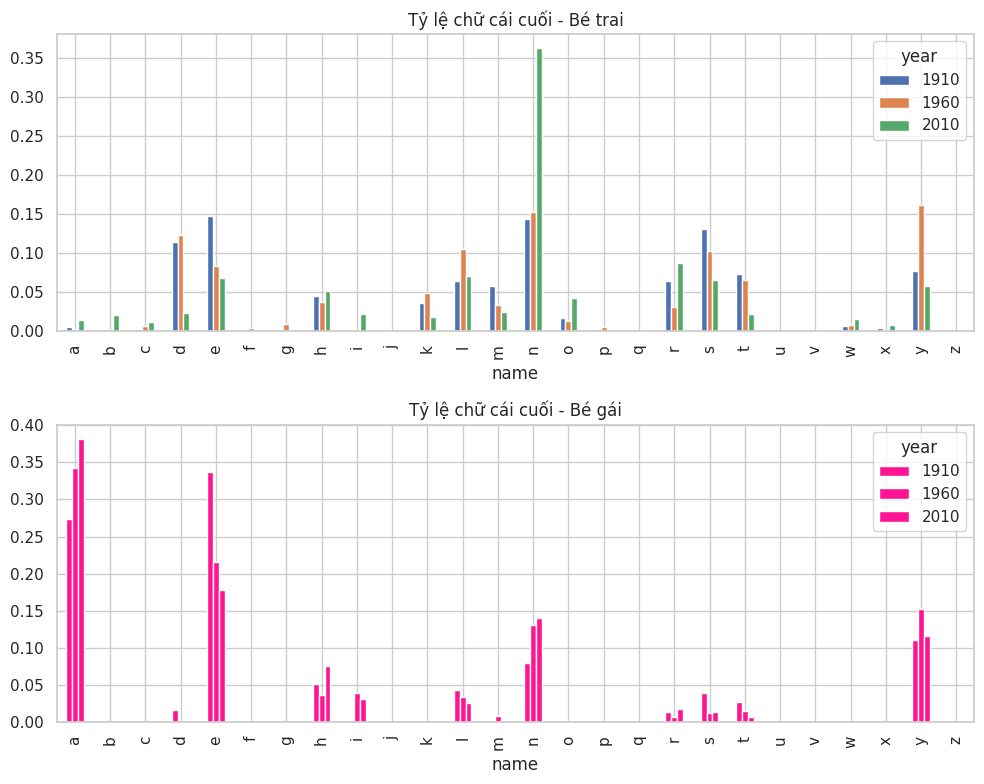

In [ ]:
last_letters = names["name"].map(lambda x: x[-1])
table = names.pivot_table("births", index=last_letters, columns=["sex", "year"], aggfunc=sum)

# Chọn các năm tiêu biểu
subtable = table.reindex(columns=[1910,1960,2010], level="year")
letter_prop = subtable / subtable.sum()

fig, axes = plt.subplots(2, 1, figsize=(10,8))
letter_prop["M"].plot(kind="bar", ax=axes[0], title="Tỷ lệ chữ cái cuối - Bé trai")
letter_prop["F"].plot(kind="bar", ax=axes[1], title="Tỷ lệ chữ cái cuối - Bé gái", color="deeppink")
plt.tight_layout()
plt.show()


Nhận xét:
Tên nữ kết thúc bằng “a” chiếm ưu thế; tên nam kết thúc bằng “n” tăng mạnh từ sau 1960.

Theo dõi riêng các chữ cái “d”, “n”, “y” (bé trai)

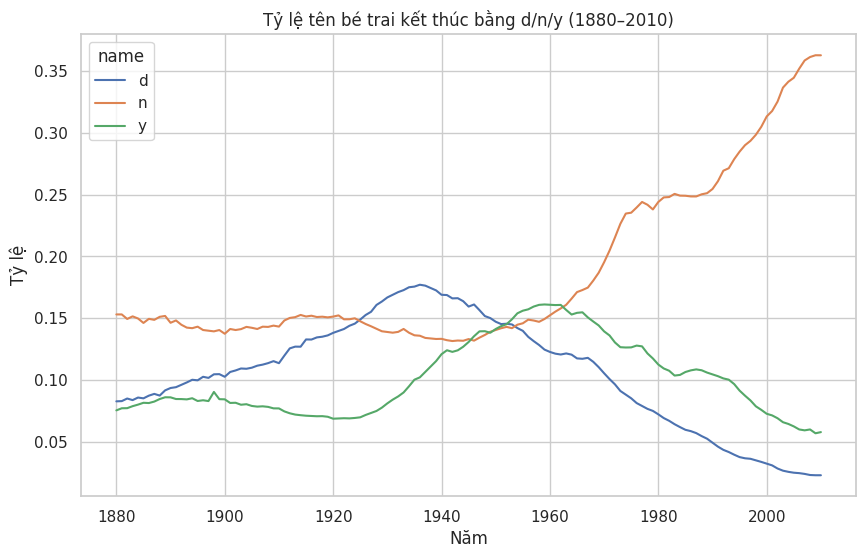

In [ ]:
letter_prop_full = table / table.sum()
dny_ts = letter_prop_full.loc[["d","n","y"],"M"].T

dny_ts.plot(figsize=(10,6))
plt.title("Tỷ lệ tên bé trai kết thúc bằng d/n/y (1880–2010)")
plt.xlabel("Năm")
plt.ylabel("Tỷ lệ")
plt.show()


Nhận xét:
Tên kết thúc bằng “n” (Ethan, Aiden, Ryan, v.v.) tăng mạnh → xu hướng hiện đại rõ rệt.

Phân tích tên unisex: ví dụ “Leslie”, “Lesley”

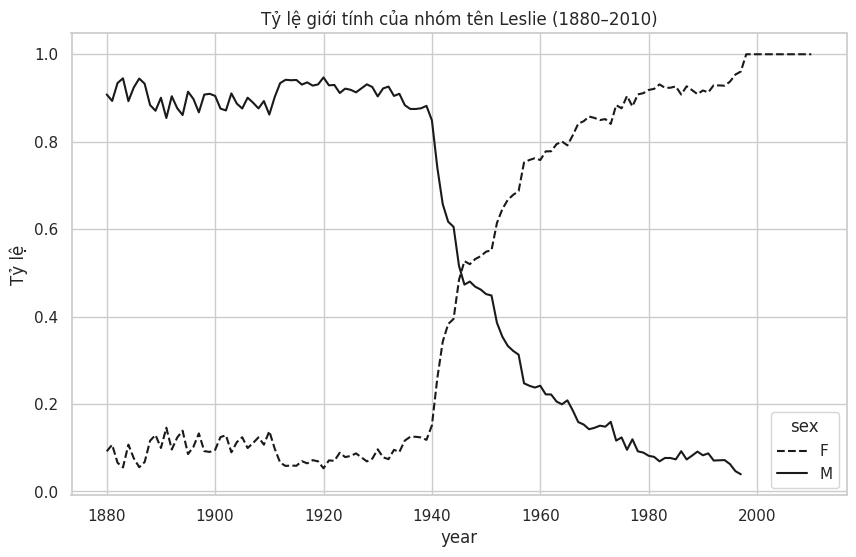

In [ ]:
lesley_like = [n for n in top1000["name"].unique() if "Lesl" in n]
filtered = top1000[top1000["name"].isin(lesley_like)]

table = filtered.pivot_table("births", index="year", columns="sex", aggfunc="sum")
table = table.div(table.sum(axis="columns"), axis="index")

table.plot(style={"M": "k-", "F": "k--"}, figsize=(10,6))
plt.title("Tỷ lệ giới tính của nhóm tên Leslie (1880–2010)")
plt.ylabel("Tỷ lệ")
plt.show()


Nhận xét:
Tên Leslie/Lesley ban đầu phổ biến cho bé trai, nhưng sau 1980 gần như chỉ còn dùng cho bé gái → minh chứng sự thay đổi xã hội qua thời gian.

Kết luận

Tổng quan:

+ Dữ liệu: ~1.7 triệu dòng (1880–2010).

+ Bé trai có số lượng sinh cao hơn bé gái.

Xu hướng:

+ Tên truyền thống giảm → cá nhân hóa tăng.

+ Độ đa dạng tăng mạnh sau 1980.

+ Bé gái luôn có tên phong phú hơn bé trai.

+ Chữ cái cuối “a” (nữ) và “n” (nam) chiếm ưu thế.

+ Một số tên chuyển giới tính theo thời gian.